# STYLE-ALIGNED WITH REFERENCE IMAGE \& CONTENT-AWARENESS  (IMG+AUDIO)

In [1]:
# Clone the repository
!git clone https://github.com/alessioborgi/StyleAlignedDiffModels.git

# Change directory to the cloned repository
%cd StyleAlignedDiffModels
%ls

# Set up Git configuration
# !git config --global user.name "Alessio Borgi"
# !git config --global user.email "alessioborgi3@gmail.com"

!git config --global user.name "Name Surname"
!git config --global user.email "email@gmail.com"

# Stage the changes
#!git add .

# Commit the changes
#!git commit -m "Added some content to your-file.txt"

# Push the changes (replace 'your-token' with your actual personal access token)
#!git push origin main

Cloning into 'StyleAlignedDiffModels'...
remote: Enumerating objects: 1573, done.
remote: Counting objects: 100% (436/436), done.
remote: Compressing objects: 100% (313/313), done.
remote: Total 1573 (delta 120), reused 432 (delta 116), pack-reused 1137 (from 1)
Receiving objects: 100% (1573/1573), 1017.95 MiB | 55.04 MiB/s, done.
Resolving deltas: 100% (697/697), done.
Updating files: 100% (338/338), done.
/content/StyleAlignedDiffModels
 audio/
 imgs/
 LICENSE
 music/
 README.md
 requirements.txt
 src/
 StyleAligned_ControlNet.ipynb
 StyleAligned_Explanation.ipynb
 StyleAligned_Focused_Attention_Explanation.ipynb
 StyleAligned_Metrics.ipynb
 StyleAligned_MultiReference_Barycentric.ipynb
 StyleAligned_MultiReference.ipynb
 StyleAligned_MultiReference_Slerp.ipynb
 StyleAligned_MultiScale_AdaIN_Explanation.ipynb
 StyleAligned_Prompts.ipynb
'StyleAligned_Ref&Content(Audio).ipynb'
'StyleAligned_Ref&Content(Audio+Music).ipynb'
'StyleAligned_Ref&Content(Img+Audio).ipynb'
'StyleAligned_Ref&C

In [2]:
# Install the required packages
!pip install -r requirements.txt > /dev/null

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albucore 0.0.13 requires numpy<2,>=1.24.4, but you have numpy 1.23.5 which is incompatible.
albumentations 1.4.13 requires numpy>=1.24.4, but you have numpy 1.23.5 which is incompatible.
chex 0.1.86 requires numpy>=1.24.1, but you have numpy 1.23.5 which is incompatible.
pandas-stubs 2.1.4.231227 requires numpy>=1.26.0; python_version < "3.13", but you have numpy 1.23.5 which is incompatible.
torchtext 0.18.0 requires torch>=2.3.0, but you have torch 2.2.2 which is incompatible.


In [3]:
from __future__ import annotations
import cv2
import copy
import torch
import einops
import mediapy
import numpy as np
from PIL import Image
import torch.nn as nn
from tqdm import tqdm
from typing import Any
from typing import Callable
from dataclasses import dataclass
from diffusers.utils import load_image
from torch.nn import functional as nnf
from diffusers.models import attention_processor
from diffusers.image_processor import PipelineImageInput
from transformers import DPTImageProcessor, DPTForDepthEstimation
from diffusers.utils.torch_utils import is_compiled_module, is_torch_version
from diffusers import StableDiffusionXLPipeline, DDIMScheduler, ControlNetModel, StableDiffusionXLControlNetPipeline, AutoencoderKL

from src.Handler import Handler
from src.StyleAlignedArgs import StyleAlignedArgs
from src.Tokenization_and_Embedding import prompt_tokenizazion_and_embedding, embeddings_ensemble, embeddings_ensemble_with_neg_conditioning
from src.Encode_Image import image_encoding
from src.Diffusion import Generate_Noise_Prediction, Denoising_next_step, DDIM_Process, extract_latent_and_inversion, DDIM_Inversion_Process

# For the Blip model (Content Image).
import os
from transformers import BlipProcessor, BlipForConditionalGeneration

# For the Whisper model (Content Audio).
from transformers import WhisperProcessor, WhisperForConditionalGeneration
import librosa

# For the Summarization and rephrasing.
from transformers import T5ForConditionalGeneration, T5Tokenizer


# Create Alias for torch.tensor to increase readability.
T = torch.tensor
TN = T

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/diffusers/utils/outputs.py:63: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
/usr/local/lib/python3.10/dist-packages/diffusers/utils/outputs.py:63: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


#### Model Load

In [4]:
# Create a DDIMScheduler object with specific parameters
scheduler = DDIMScheduler(
    beta_start=0.00085,            # Starting value of beta for the noise schedule
    beta_end=0.012,                # Ending value of beta for the noise schedule
    beta_schedule="scaled_linear", # Type of beta schedule to use, here it is scaled linear
    clip_sample=False,             # Whether to clip the samples to a certain range
    set_alpha_to_one=False         # Whether to set alpha to one
)

# Load the Stable Diffusion XL Reference_Pipeline with a pretrained model
Reference_Pipeline = StableDiffusionXLPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-base-1.0",  # Model name or path
    torch_dtype=torch.float16,                   # Data type for PyTorch tensors
    variant="fp16",                              # Variant of the model, here it is fp16 (16-bit floating point)
    use_safetensors=True,                        # Whether to use safe tensors
    scheduler=scheduler                          # Use the scheduler defined above
).to("cuda")                                     # Move the pipeline to the CUDA device (GPU)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


model_index.json:   0%|          | 0.00/609 [00:00<?, ?B/s]

Fetching 18 files:   0%|          | 0/18 [00:00<?, ?it/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/565 [00:00<?, ?B/s]

text_encoder_2/config.json:   0%|          | 0.00/575 [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

model.fp16.safetensors:   0%|          | 0.00/1.39G [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

model.fp16.safetensors:   0%|          | 0.00/246M [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/737 [00:00<?, ?B/s]

tokenizer_2/special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

tokenizer_2/tokenizer_config.json:   0%|          | 0.00/725 [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/1.68k [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/5.14G [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/642 [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [5]:
# 1) VanGogh Painting
# Set the source style, prompt and path.
src_style = "Van Gogh round painting"
src_prompt = f'The starry night, {src_style}.'
reference_image_path = './imgs/original.jpg'

# 2) Cubism Painting
# src_style = "cubism painting"
# src_prompt = f'Two men smoking water pipe, {src_style}.'
# reference_image_path = './imgs/Picasso_Smoking_Water_Pipe.jpeg'


# 3) Kid Drawing
# src_style = "Kid Drawing"
# src_prompt = f'A city with two houses and a church, {src_style}.'
# reference_image_path = './imgs/kid_drawing.jpeg'

# 4) Medieval Painting
# src_style = "Medieval Painting"
# src_prompt = f'Man laying in a bed, {src_style}.'
# reference_image_path = './imgs/medieval-bed.jpeg'

# Setting the number of inference steps in the Diffusion Inversion Process.
num_inference_steps = 50

# Setting the Guidance Scale for the Diffusion Inversion Process.
guidance_scale = 25.0

# 1) Normal Painting
# These are some parameters you can Adjust to Control StyleAlignment to Reference Image.
#style_alignment_score_shift = np.log(2)  # higher value induces higher fidelity, set 0 for no shift
#style_alignment_score_scale = 1.0  # higher value induces higher, set 1 for no rescale

# 2) Very Famous Paintings
style_alignment_score_shift = np.log(1)
style_alignment_score_scale = 0.5

Reference Image for Style Alignment

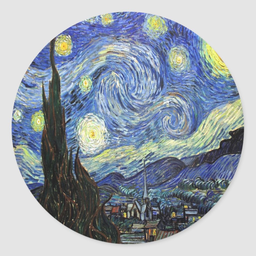

In [6]:
# Load the reference image and resize it to 1024x1024 pixels.
ref_image = np.array(load_image(reference_image_path).resize((1024, 1024)))

# Display the output image.
mediapy.show_image(ref_image, title="Reference Image for Style Alignment", height=256)

In [7]:
# Defining a type alias for the Diffusion Inversion Process type of callable.
Diff_Inversion_Process_Callback = Callable[[StableDiffusionXLPipeline, int, T, dict[str, T]], dict[str, T]]

### CONTENT IMAGE USING BLIP-1

In [8]:
processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")

preprocessor_config.json:   0%|          | 0.00/287 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/506 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/990M [00:00<?, ?B/s]

In [9]:
def generate_description(image):
    inputs = processor(image, return_tensors="pt")
    out = model.generate(**inputs)
    description = processor.decode(out[0], skip_special_tokens=True)
    return description

In [10]:
def load_content_images(image_paths):
    """
    Load images from a list of file paths.

    Parameters:
    image_paths (List[str]): A list of file paths to the images.

    Returns:
    List[Image.Image]: A list of PIL Image objects.
    """
    content_images = []
    for img_path in image_paths:
        try:
            image = Image.open(img_path)
            content_images.append(image)
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")

    return content_images

In [11]:
directory_path = "/content/StyleAlignedDiffModels/imgs/content_imgs/"
# set_of_images = ["ladybug.jpeg", "PolarBear.jpeg", "cat_playing.jpeg"]
set_of_images = ["cat_playing.jpeg", "key.jpeg", "olive_tree.jpg"]
set_of_images_path = [directory_path + img for img in set_of_images]
print(set_of_images_path)
content_images = load_content_images(set_of_images_path)  # Implement this as needed

['/content/StyleAlignedDiffModels/imgs/content_imgs/cat_playing.jpeg', '/content/StyleAlignedDiffModels/imgs/content_imgs/key.jpeg', '/content/StyleAlignedDiffModels/imgs/content_imgs/olive_tree.jpg']


In [12]:
extracted_prompts_img = [generate_description(image).strip() + "." for image in content_images]
print(extracted_prompts_img)

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1249: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


['a cat playing with a ball in the grass.', 'a key on a wooden surface.', 'olive tree in the field.']


### AUDIO CONTENT

In [13]:
# Load the Whisper model and processor
processor = WhisperProcessor.from_pretrained("openai/whisper-small")
model = WhisperForConditionalGeneration.from_pretrained("openai/whisper-small")
model.eval()

preprocessor_config.json:   0%|          | 0.00/185k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/283k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/836k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.48M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/494k [00:00<?, ?B/s]

normalizer.json:   0%|          | 0.00/52.7k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/34.6k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.19k [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


config.json:   0%|          | 0.00/1.97k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/967M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/3.87k [00:00<?, ?B/s]

WhisperForConditionalGeneration(
  (model): WhisperModel(
    (encoder): WhisperEncoder(
      (conv1): Conv1d(80, 768, kernel_size=(3,), stride=(1,), padding=(1,))
      (conv2): Conv1d(768, 768, kernel_size=(3,), stride=(2,), padding=(1,))
      (embed_positions): Embedding(1500, 768)
      (layers): ModuleList(
        (0-11): 12 x WhisperEncoderLayer(
          (self_attn): WhisperSdpaAttention(
            (k_proj): Linear(in_features=768, out_features=768, bias=False)
            (v_proj): Linear(in_features=768, out_features=768, bias=True)
            (q_proj): Linear(in_features=768, out_features=768, bias=True)
            (out_proj): Linear(in_features=768, out_features=768, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (activation_fn): GELUActivation()
          (fc1): Linear(in_features=768, out_features=3072, bias=True)
          (fc2): Linear(in_features=3072, out_features=768, bias=True)
        

In [14]:
def audio_to_text_batch(audio_paths, sampling_rate=16000):
    transcriptions = []
    for audio_path in audio_paths:
        # Load the audio file with an explicit sampling rate
        audio, _ = librosa.load(audio_path, sr=sampling_rate)

        # Process the audio to extract features
        input_features = processor(audio, sampling_rate=sampling_rate, return_tensors="pt").input_features

        # Generate the text from audio features
        with torch.no_grad():
            predicted_ids = model.generate(input_features)

        # Decode the generated ids to text
        transcription = processor.batch_decode(predicted_ids, skip_special_tokens=True)[0]
        transcriptions.append(transcription)
    return transcriptions

In [15]:
# Step 2: Convert each audio file to text
audio_path = "/content/StyleAlignedDiffModels/audio/"
audio_paths = ["cat_playing.wav", "keys.wav", "olive_tree.wav"]
set_of_audio_path = [audio_path + audio for audio in audio_paths]

audio_descriptions = audio_to_text_batch(set_of_audio_path)
print("Audio Descriptions: ", audio_descriptions)

Due to a bug fix in https://github.com/huggingface/transformers/pull/28687 transcription using a multilingual Whisper will default to language detection followed by transcription instead of translation to English.This might be a breaking change for your use case. If you want to instead always translate your audio to English, make sure to pass `language='en'`.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token.As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


Audio Descriptions:  [' An Egyptian cat playing with a ball.', ' A pair of keys lying on the table in the garden.', ' An olive tree in an olive grove with some beehives around it.']


### IMG + AUDIO CONTENT

In [16]:
# Step 3: Combine each image description with its corresponding audio description
combined_descriptions = [
    img_desc + " " + audio_desc
    for img_desc, audio_desc in zip(extracted_prompts_img, audio_descriptions)
]
print("Non-Summarized Text: ", combined_descriptions)

Non-Summarized Text:  ['a cat playing with a ball in the grass.  An Egyptian cat playing with a ball.', 'a key on a wooden surface.  A pair of keys lying on the table in the garden.', 'olive tree in the field.  An olive tree in an olive grove with some beehives around it.']


### SUMMARIZATION STEP

In [17]:
# Load the T5 model and tokenizer
model_T5 = T5ForConditionalGeneration.from_pretrained("t5-small")
tokenizer_T5 = T5Tokenizer.from_pretrained("t5-small")

# Combine the sentences
input_text = [f"Summarize: " + phrase for phrase in combined_descriptions]

# Tokenize the input text
input_ids = [tokenizer_T5.encode(input_phrase, return_tensors="pt", truncation=True) for input_phrase in input_text]

# Generate the summary
summary_ids = [model_T5.generate(input_tknz, max_length=50, min_length=5, length_penalty=1.5, num_beams=4, early_stopping=True) for input_tknz in input_ids]

# Decode the generated summary
summary_descriptions = [tokenizer_T5.decode(summary_ids[i][0], skip_special_tokens=True) for i in range(len(summary_ids))]

print("Summary:", summary_descriptions)

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Summary: ['an Egyptian cat playing with a ball in the grass.', 'a pair of keys lying on the table in the garden.', 'olive tree in an olive grove with some beehives around it.']


In [18]:
# Set of prompts to generate images for. The first refers to the Reference Image. The other to generate images.
prompts = [
    src_prompt,  # Reference Image Prompt
    *summary_descriptions  # Prompts extracted from content + audio images
]
print(prompts)

# Append the reference style to each of subsequent prompts for generating images with the same Style.
for i in range(1, len(prompts)):
    prompts[i] = f'{prompts[i]}, {src_style}.'

# Configure the StyleAligned Handler using the StyleAlignedArgs.
handler = Handler(Reference_Pipeline)
sa_args = StyleAlignedArgs(
    share_group_norm=True,
    share_layer_norm=True,
    share_attention=True,
    adain_queries=True,
    adain_keys=True,
    adain_values=False,
    style_alignment_score_shift=style_alignment_score_shift,
    style_alignment_score_scale=style_alignment_score_scale)
handler.register(sa_args)

['The starry night, Van Gogh round painting.', 'an Egyptian cat playing with a ball in the grass.', 'a pair of keys lying on the table in the garden.', 'olive tree in an olive grove with some beehives around it.']


In [19]:
# Execute the Diffusion Inversion Process to map the reference image to its latent representation.
DDIM_inv_result = DDIM_Inversion_Process(Reference_Pipeline, ref_image, src_prompt, num_inference_steps, 2)

# Extract the latent representation from the Diffusion Inversion Result that can be used to guide the generation of new images in the desired style.
latent_vector_ref_img, inversion_callback = extract_latent_and_inversion(DDIM_inv_result, offset=5)

# Create a Random Number Generator on the CPU.
rand_gen = torch.Generator(device='cpu').manual_seed(10)

# Generate the images using the latent representation of the reference image as guidance.
latents = torch.randn(len(prompts), 4, 128, 128,                            # Random Latent Vectors shape
                      device='cpu',                                         # Latent Vectors on CPU.
                      generator=rand_gen,                                   # Random Number Generator.
                      dtype=Reference_Pipeline.unet.dtype,).to('cuda:0')    # Data Type of the Latent Vectors (same as required by the model's UNet).

# Set the first latent vector to the latent representation of the reference image extracted before.
latents[0] = latent_vector_ref_img

# Generate the images using the provided prompts and the latent vectors.
images_a = Reference_Pipeline(prompts,                                      # Prompts to generate images for.
                              latents=latents,                              # Latent Vectors to guide the generation of images.
                              callback_on_step_end=inversion_callback,      # Callback to update the latent vectors during the generation process.
                              num_inference_steps=num_inference_steps,      # Number of Inference Steps to generate the images.
                              guidance_scale=guidance_scale).images         # Guidance Scale to control the influence of the latent vectors on the generated images.

# Display the generated images.
handler.remove()
mediapy.show_images(images_a, titles=[p[:-(len(src_style) + 3)] for p in prompts])

100%|██████████| 50/50 [01:02<00:00,  1.25s/it]


  0%|          | 0/50 [00:00<?, ?it/s]

OutOfMemoryError: CUDA out of memory. Tried to allocate 4.00 GiB. GPU 0 has a total capacity of 14.75 GiB of which 3.57 GiB is free. Process 33807 has 11.18 GiB memory in use. Of the allocated memory 9.73 GiB is allocated by PyTorch, and 1.30 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
import tensorflow as tf
import torch

def clear_gpu_memory():
    # Clear TensorFlow GPU memory
    tf.keras.backend.clear_session()
    tf.compat.v1.reset_default_graph()

    # Clear PyTorch GPU memory
    torch.cuda.empty_cache()
    torch.cuda.ipc_collect()

    print("GPU memory cleared.")

# Execute the function to clear GPU memory
clear_gpu_memory()
